## Sentiment Analysis using BERT

In [17]:
#Import packages
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import tqdm

#Set working directory
cwd = os.getcwd()

In [18]:
#Import the dataframes
df_comment = pd.read_csv(cwd+"/data/Comment_dataset_processed.csv")
df_submission = pd.read_csv(cwd+"/data/Post_dataset_processed.csv")

In [19]:
#Import the tokenized and model
tokenizer = AutoTokenizer.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis")
model = TFAutoModelForSequenceClassification.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at rabindralamsal/finetuned-bertweet-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Percentage of rows that exceed a length of 130:  0.13625428120531563


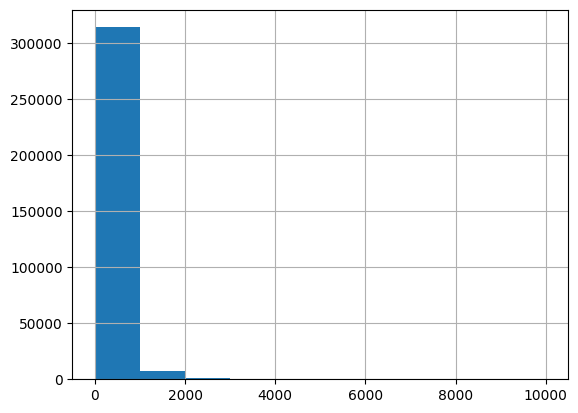

In [27]:
#Plotting the length of the "Comment Text" column
df_comment['Comment Text'].str.len().hist()

#Printing the percentage of rows that exceed a length of 130
print("Percentage of rows that exceed a length of 130: ", len(df_comment[df_comment['Comment Text'].str.len() > 390])/len(df_comment))

### Getting the sentiment score

In [7]:
#To explain how it works, we will use the following sentence:
sentence = "[Official] ChatGPT now supports plugins!!!	"
sentence = sentence.lower()
#We will use the tokenizer to encode the sentence
input = tokenizer.encode(sentence, return_tensors="tf")
#We will use the model to predict the sentiment
tf.nn.sigmoid(model.predict(input)[0][0]).numpy()

1/1 [==============================] - 8s 8s/step


array([0.01938671, 0.8629262 , 0.8390463 ], dtype=float32)

The array shown above shows the probability of the sentence being negative, neutral or positive (in that order). The sentence has a high probability of being positive. However, the probability of neutral is even higher.
The final label of that sentence would be neutral. Since there are a lot of neutral sentences in the database, the decision has been made to base the sentiment upon the amount of negative versus positive probability.
This means that the final sentiment will be a sum of the product of negative probability times -1, and the product of positive probability times 1.
The following calculates this sentiment.


In [20]:
#Gettingt the sentiment score for a sentence
def classify(sentence:str):
    """
    Takes a sentence and returns a sentiment score between -1 and 1:
    -1 represents "negative" sentiment
    0 represents "neutral" sentiment
    1 represents "positive" sentiment
    """
    sentence = sentence.lower()
    input = tokenizer.encode(sentence, return_tensors="tf")
    probability_neg = tf.nn.sigmoid(model.predict(input)[0][0]).numpy()[0]
    probability_pos = tf.nn.sigmoid(model.predict(input)[0][0]).numpy()[2]

    sentiment = (probability_neg * -1) + (probability_pos * 1)
    return sentiment

In [21]:
#Adding the sentiment score to the df based on text in one column
def sentiment_score(df_file:pd.DataFrame, column_name:str):
    """
    Assign a preprocessed dataframe to df_file
    Assign a single column name to column_name for the text to be used for sentiment analysis
    Applies the classify function to the column_name
    Returns a dataframe with a new column "Sentiment" with the sentiment score
    """
    sentiment_score = []
    for index, sentence in enumerate(df_file[column_name]):
        sentiment_score.append(classify(sentence))

    df_file["Sentiment"] = sentiment_score
    return df_file

In [22]:
#Calling the function
df_submission_score = sentiment_score(df_file = df_comment, column_name = "Comment Text")

1/1 [==============================] - 0s 109ms/step


InvalidArgumentError: Graph execution error:

Detected at node 'tf_roberta_for_sequence_classification_2/roberta/embeddings/Gather_1' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\noort\AppData\Local\Temp\ipykernel_16052\99331425.py", line 2, in <module>
      df_submission_score = sentiment_score(df_file = df_comment, column_name = "Comment Text")
    File "C:\Users\noort\AppData\Local\Temp\ipykernel_16052\1945603209.py", line 11, in sentiment_score
      sentiment_score.append(classify(sentence))
    File "C:\Users\noort\AppData\Local\Temp\ipykernel_16052\1063767507.py", line 11, in classify
      probability_neg = tf.nn.sigmoid(model.predict(input)[0][0]).numpy()[0]
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\modeling_tf_utils.py", line 1347, in run_call_with_unpacked_inputs
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 1359, in call
      outputs = self.roberta(
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\modeling_tf_utils.py", line 1347, in run_call_with_unpacked_inputs
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 662, in call
      embedding_output = self.embeddings(
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\noort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 175, in call
      position_embeds = tf.gather(params=self.position_embeddings, indices=position_ids)
Node: 'tf_roberta_for_sequence_classification_2/roberta/embeddings/Gather_1'
indices[0,128] = 130 is not in [0, 130)
	 [[{{node tf_roberta_for_sequence_classification_2/roberta/embeddings/Gather_1}}]] [Op:__inference_predict_function_173970]

What the sentiment score looks like:
0    0.231949
1    0.302149
2   -0.852026
3    0.808798
4    0.897458
Name: Sentiment, dtype: float64

Quick overview of the distribution of the sentiment score:
Axes(0.125,0.11;0.775x0.77)



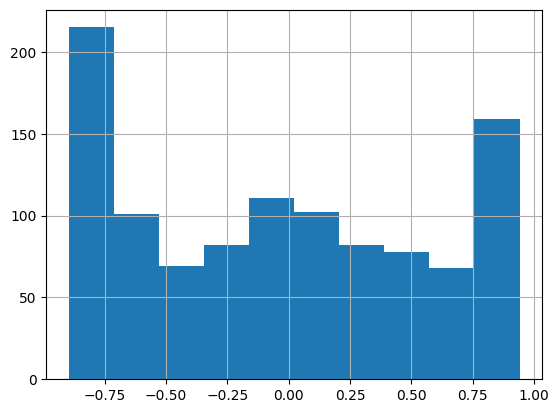

In [14]:
#Visualizing the results
print(f"What the sentiment score looks like:\n{df_submission_score['Sentiment'].head()}\n")
print(f"Quick overview of the distribution of the sentiment score:\n{df_submission_score['Sentiment'].hist()}\n")
